# Figures comparing `empymod` to analytical solution and to `EMmod`

   1. Comparing `empymod` and `EMmod` with analytical half-space solution.
   2. Comparing run times of `EMmod` and different Hankel transform parameters of `emmod`.
   
*This notebook is to reproduce the results from the article. For more information see the article in the parent directory.*

In [1]:
import os
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Load dipole- and analytical routines
from empymod import dipole, analytical

# Plotting style adjustments
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.serif'] = 'Computer Modern Roman'
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.style'] = 'normal'

# Set axis and limits
def limits(i):
    plt.sca(axs[i])
    plt.xlim(min(x)/1000, max(x)/1000)
    plt.ylim(min(x)/1000, max(x)/1000)
    plt.axis('equal')    

## Model parameters, as in halfspacemod.src from Hunziker et al., 2015

In [2]:
# Define coordinates
x = (np.arange(1051))*10-500
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()
params = {
    'src': [0, 0, 150],
    'rec': [rx.ravel(), ry.ravel(), 200],
    'depth': 0,
    'res': [1e20, 1/3],
    'freqtime': 0.5,
    'ab': 11,
    'aniso': [1, np.sqrt(3/.3)],
    'epermH': [1, 80],
    'epermV': [1, 80],
    'mpermH': [1, 1],
    'mpermV': [1, 1],
    'xdirect': False,
    'verb': 0,
}

## Calculate and plot analytical solution

In [3]:
# 1. Analytical solution
resp = analytical(params['src'], params['rec'], params['res'][1], params['freqtime'],
                  solution='dhs', aniso=params['aniso'][1], ab=params['ab'])
resp = resp.reshape(np.shape(rx))

* WARNING :: Offsets < 0.001 m are set to 0.001 m!

:: empymod END; runtime = 0:00:07.677001 :: 



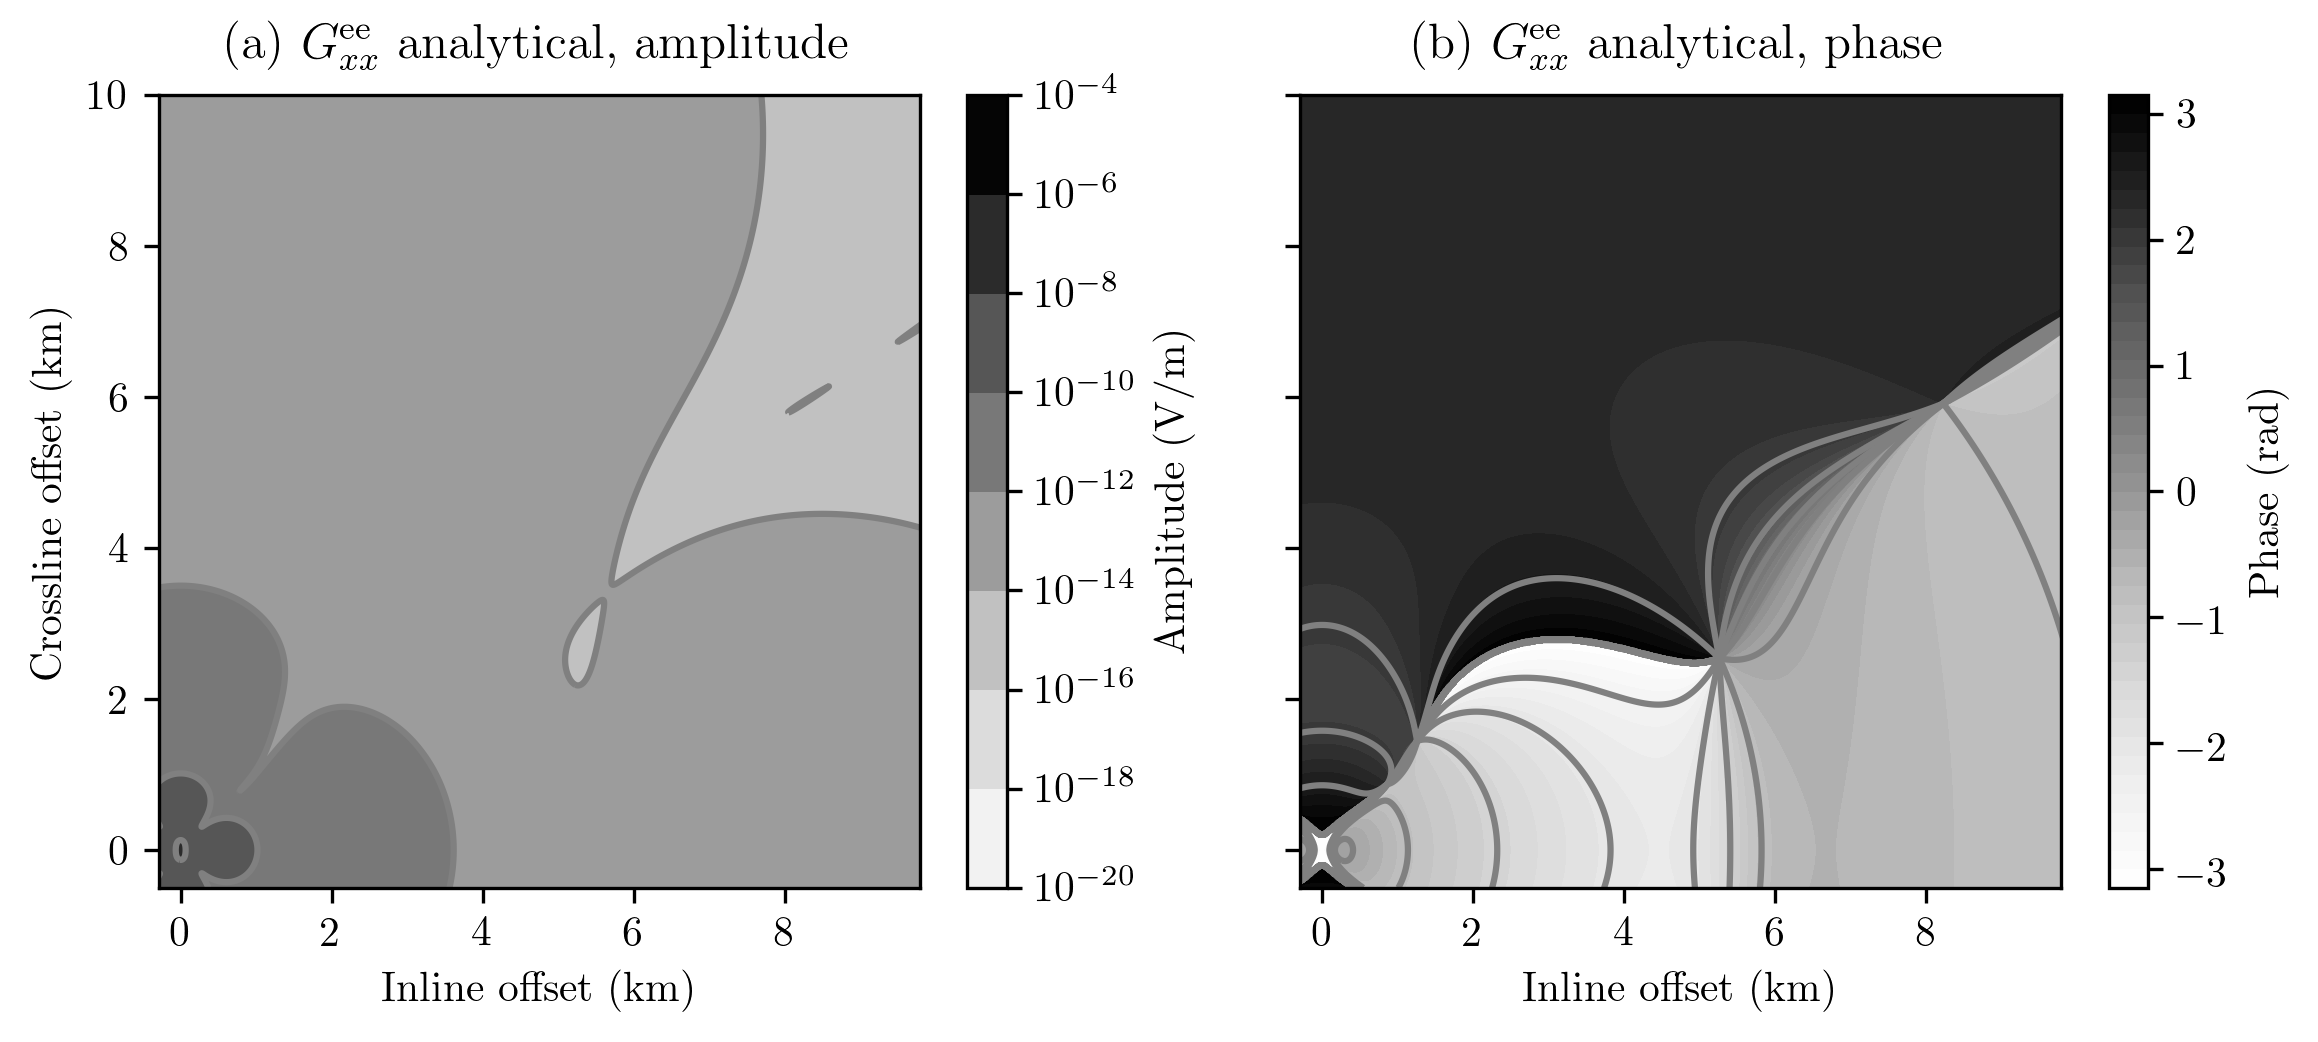

In [4]:
fig, axs = plt.subplots(figsize=(9, 3.5), facecolor = 'w', nrows=1, ncols=2, sharey=True)
axs = axs.ravel()


# 1. AMPLITUDE; Set axis and limits
limits(0)

# Title and labels
plt.title(r'(a) $G^{\rm{ee}}_{xx}$ analytical, amplitude')
plt.ylabel('Crossline offset (km)')
plt.xlabel('Inline offset (km)')

# Draw filled contours and contour lines
cf1 = plt.contourf(rx/1000, ry/1000, np.abs(resp), 10, locator=mpl.ticker.LogLocator(), cmap='Greys')
cf1l = plt.contour(cf1, colors='.5', linestyles='solid')

# Plot colorbar
cb1 = plt.colorbar(cf1)
cb1.set_label('Amplitude $(\\rm{V}/\\rm{m})$')


# 2. PHASE; Set axis and limits
limits(1)

vmin2 = -np.pi
vmax2 = np.pi

# Title and labels
plt.title(r'(b) $G^{\rm{ee}}_{xx}$ analytical, phase')
plt.xlabel('Inline offset (km)')

# Draw filled contours and contour lines
cf2 = plt.contourf(rx/1000, ry/1000, np.angle(resp), 50, vmin=vmin2, vmax=vmax2, cmap='Greys')
cf2l = plt.contour(cf2, levels=np.linspace(-np.pi, np.pi, 12), colors='.5', linestyles='solid')

# Plot colourbar
cb2 = plt.colorbar(cf2, ticks=np.arange(7)-3)
cb2.set_label('Phase $(\\rm{rad})$')

# Save figure and show it
plt.savefig('../figures/analytical.jpg', bbox_inches='tight')
plt.show()

## Calculate `empymod` for different Hankel transforms

### Function to calculate error

In [5]:
def calc_err(params, ht=None, htarg=None, loop=None, opt=None):

    # The model is very big (1 million cells), so it gives a very detailed view of the error,
    # as used by Hunziker et al 2015. However, this is more an academic use. On my laptop, all
    # except the lagged FHT would fail due to memory issues. Hence I carry out the calculation
    # in loops. More 'industry'-like values can be seen in Key 2012.
    if loop:
        inpresp = np.zeros(rx.ravel().shape, dtype=complex)
        for i in range(37):
            cc = 30000
            params['rec'] = [rx.ravel()[i*cc:(i+1)*cc], ry.ravel()[i*cc:(i+1)*cc], 200]
            inpresp[i*cc:(i+1)*cc] = dipole(**params, ht=ht, htarg=htarg, opt=opt)
        params['rec'] = [rx.ravel(), ry.ravel(), 200]
    else:
        inpresp = dipole(**params, ht=ht, htarg=htarg, opt=opt)
        
    # Reshape and calculate log10-error for phase and amplitude
    inpresp = inpresp.reshape(np.shape(rx))
    amperr = np.abs((np.abs(resp) - np.abs(inpresp))/np.abs(resp))*100
    phaerr = np.abs((np.angle(resp) - np.angle(inpresp))/np.angle(resp))*100
    
    return amperr, phaerr

The calculation is time intensive. It therefore stores the result in *./data*, and only calculates it, if those files don't exist.

In [6]:
if os.path.isfile('./data/qwe1err.npz'):  # If results exist, load them
    qwe1amp, qwe1pha = np.load('data/qwe1err.npz')['amp'], np.load('data/qwe1err.npz')['pha']
    qwe2amp, qwe2pha = np.load('data/qwe2err.npz')['amp'], np.load('data/qwe2err.npz')['pha']
    qwe3amp, qwe3pha = np.load('data/qwe3err.npz')['amp'], np.load('data/qwe3err.npz')['pha']
    fht1amp, fht1pha = np.load('data/fht1err.npz')['amp'], np.load('data/fht1err.npz')['pha']
    fht2amp, fht2pha = np.load('data/fht2err.npz')['amp'], np.load('data/fht2err.npz')['pha']
    fht3amp, fht3pha = np.load('data/fht3err.npz')['amp'], np.load('data/fht3err.npz')['pha']
    
else:  # If not pre-calculated, run empymod
    # Calculate the QWE models
    qwe1amp, qwe1pha = calc_err(params, ht='QWE', htarg={'maxint': 40}, loop=True)
    np.savez('data/qwe1err', amp=qwe1amp, pha=qwe1pha)
    print('QWE 1 finished')
    qwe2amp, qwe2pha = calc_err(params, ht='QWE', htarg=[1e-8, 1e-30, 21, 40], loop=True)
    np.savez('data/qwe2err', amp=qwe2amp, pha=qwe2pha)
    print('QWE 2 finished')
    qwe3amp, qwe3pha = calc_err(params, ht='QWE', htarg=[1e-8, 1e-18, 15, 40], loop=True)
    np.savez('data/qwe3err', amp=qwe3amp, pha=qwe3pha)
    print('QWE 3 finished')

    # Calculate the FHT models
    fht1amp, fht1pha = calc_err(params, ht='FHT', loop=True)
    np.savez('data/fht1err', amp=fht1amp, pha=fht1pha)
    print('FHT 1 finished')
    fht2amp, fht2pha = calc_err(params, ht='FHT', htarg={'pts_per_dec': 40}, opt='spline', loop=True)
    np.savez('data/fht2err', amp=fht2amp, pha=fht2pha)
    print('FHT 2 finished')
    fht3amp, fht3pha = calc_err(params, ht='FHT', opt='spline')
    np.savez('data/fht3err', amp=fht3amp, pha=fht3pha)
    print('FHT 3 finished')

QWE 1 finished
QWE 2 finished
QWE 3 finished
FHT 1 finished
FHT 2 finished
FHT 3 finished


## Plot amplitude error of `empymod`

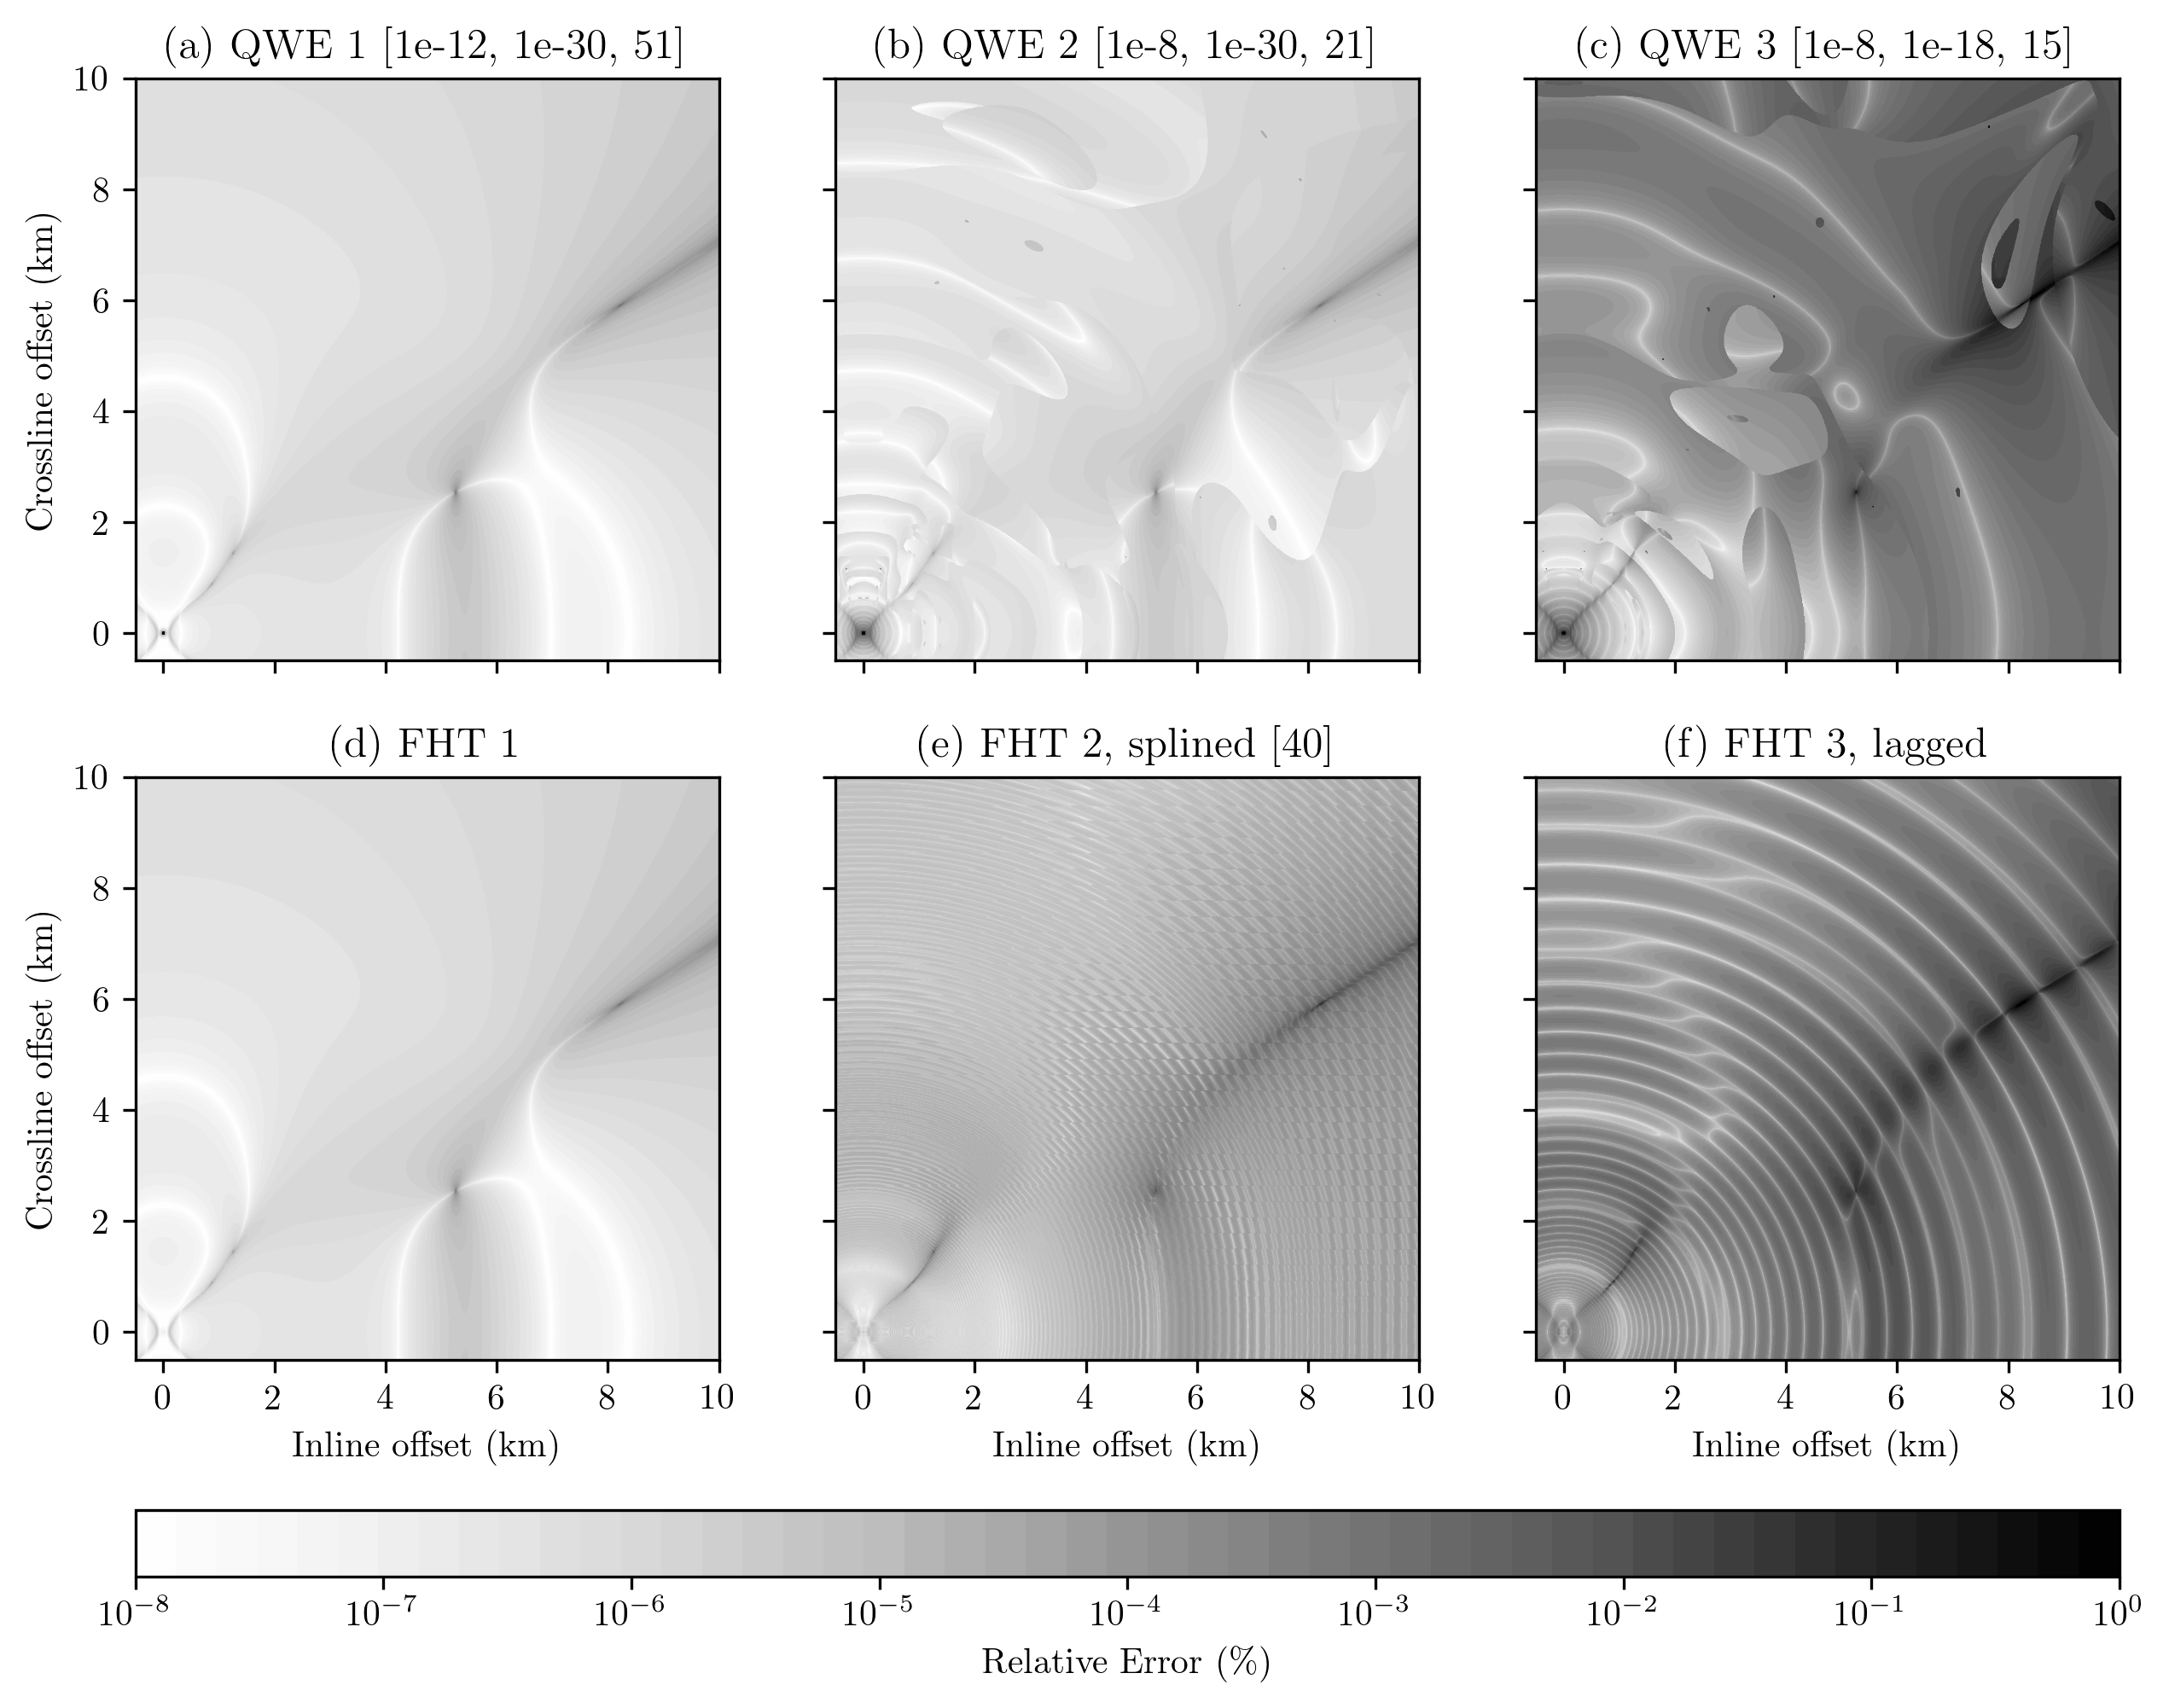

In [7]:
fig, axs = plt.subplots(figsize=(10, 7.8), facecolor = 'w', nrows=2, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()

# Min and max, properties
vmin = 1e-8
vmax = 1e0
props = {'levels': np.logspace(np.log10(vmin), np.log10(vmax), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

# QWE 1
limits(0)
plt.title(r'(a) QWE 1 [1e-12, 1e-30, 51]')
cf1 = plt.contourf(rx/1000, ry/1000, qwe1amp.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

# QWE 2
limits(1)
plt.title(r'(b) QWE 2 [1e-8, 1e-30, 21]')
cf2 = plt.contourf(rx/1000, ry/1000, qwe2amp.clip(vmin, vmax), **props)

# QWE 3
limits(2)
plt.title(r'(c) QWE 3 [1e-8, 1e-18, 15]')
cf3 = plt.contourf(rx/1000, ry/1000, qwe3amp.clip(vmin, vmax), **props)

# FHT 1
limits(3)
plt.title(r'(d) FHT 1')
cf4 = plt.contourf(rx/1000, ry/1000, fht1amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')
plt.ylabel('Crossline offset (km)')
plt.xticks(np.arange(6)*2)


# FHT 2 (splined)
limits(4)
plt.title(r'(e) FHT 2, splined [40]')
cf5 = plt.contourf(rx/1000, ry/1000, fht2amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# FHT 3 (lagged)
limits(5)
plt.title(r'(f) FHT 3, lagged')
cf6 = plt.contourf(rx/1000, ry/1000, fht3amp.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# Plot colorbar
cax, kw = mpl.colorbar.make_axes([axs[0], axs[1], axs[2], axs[3], axs[4], axs[5]],
                                 location='bottom', fraction=.05, pad=0.1, aspect=30)
cb = plt.colorbar(cf6, cax=cax, ticks=10**(-(np.arange(11.)[::-1])+2), **kw)
cb.set_label(r'Relative Error $(\%)$')

# Save and show
plt.savefig('../figures/onederror-amplitude.jpg', bbox_inches='tight')
plt.show()

## Plot phase error of `empymod`

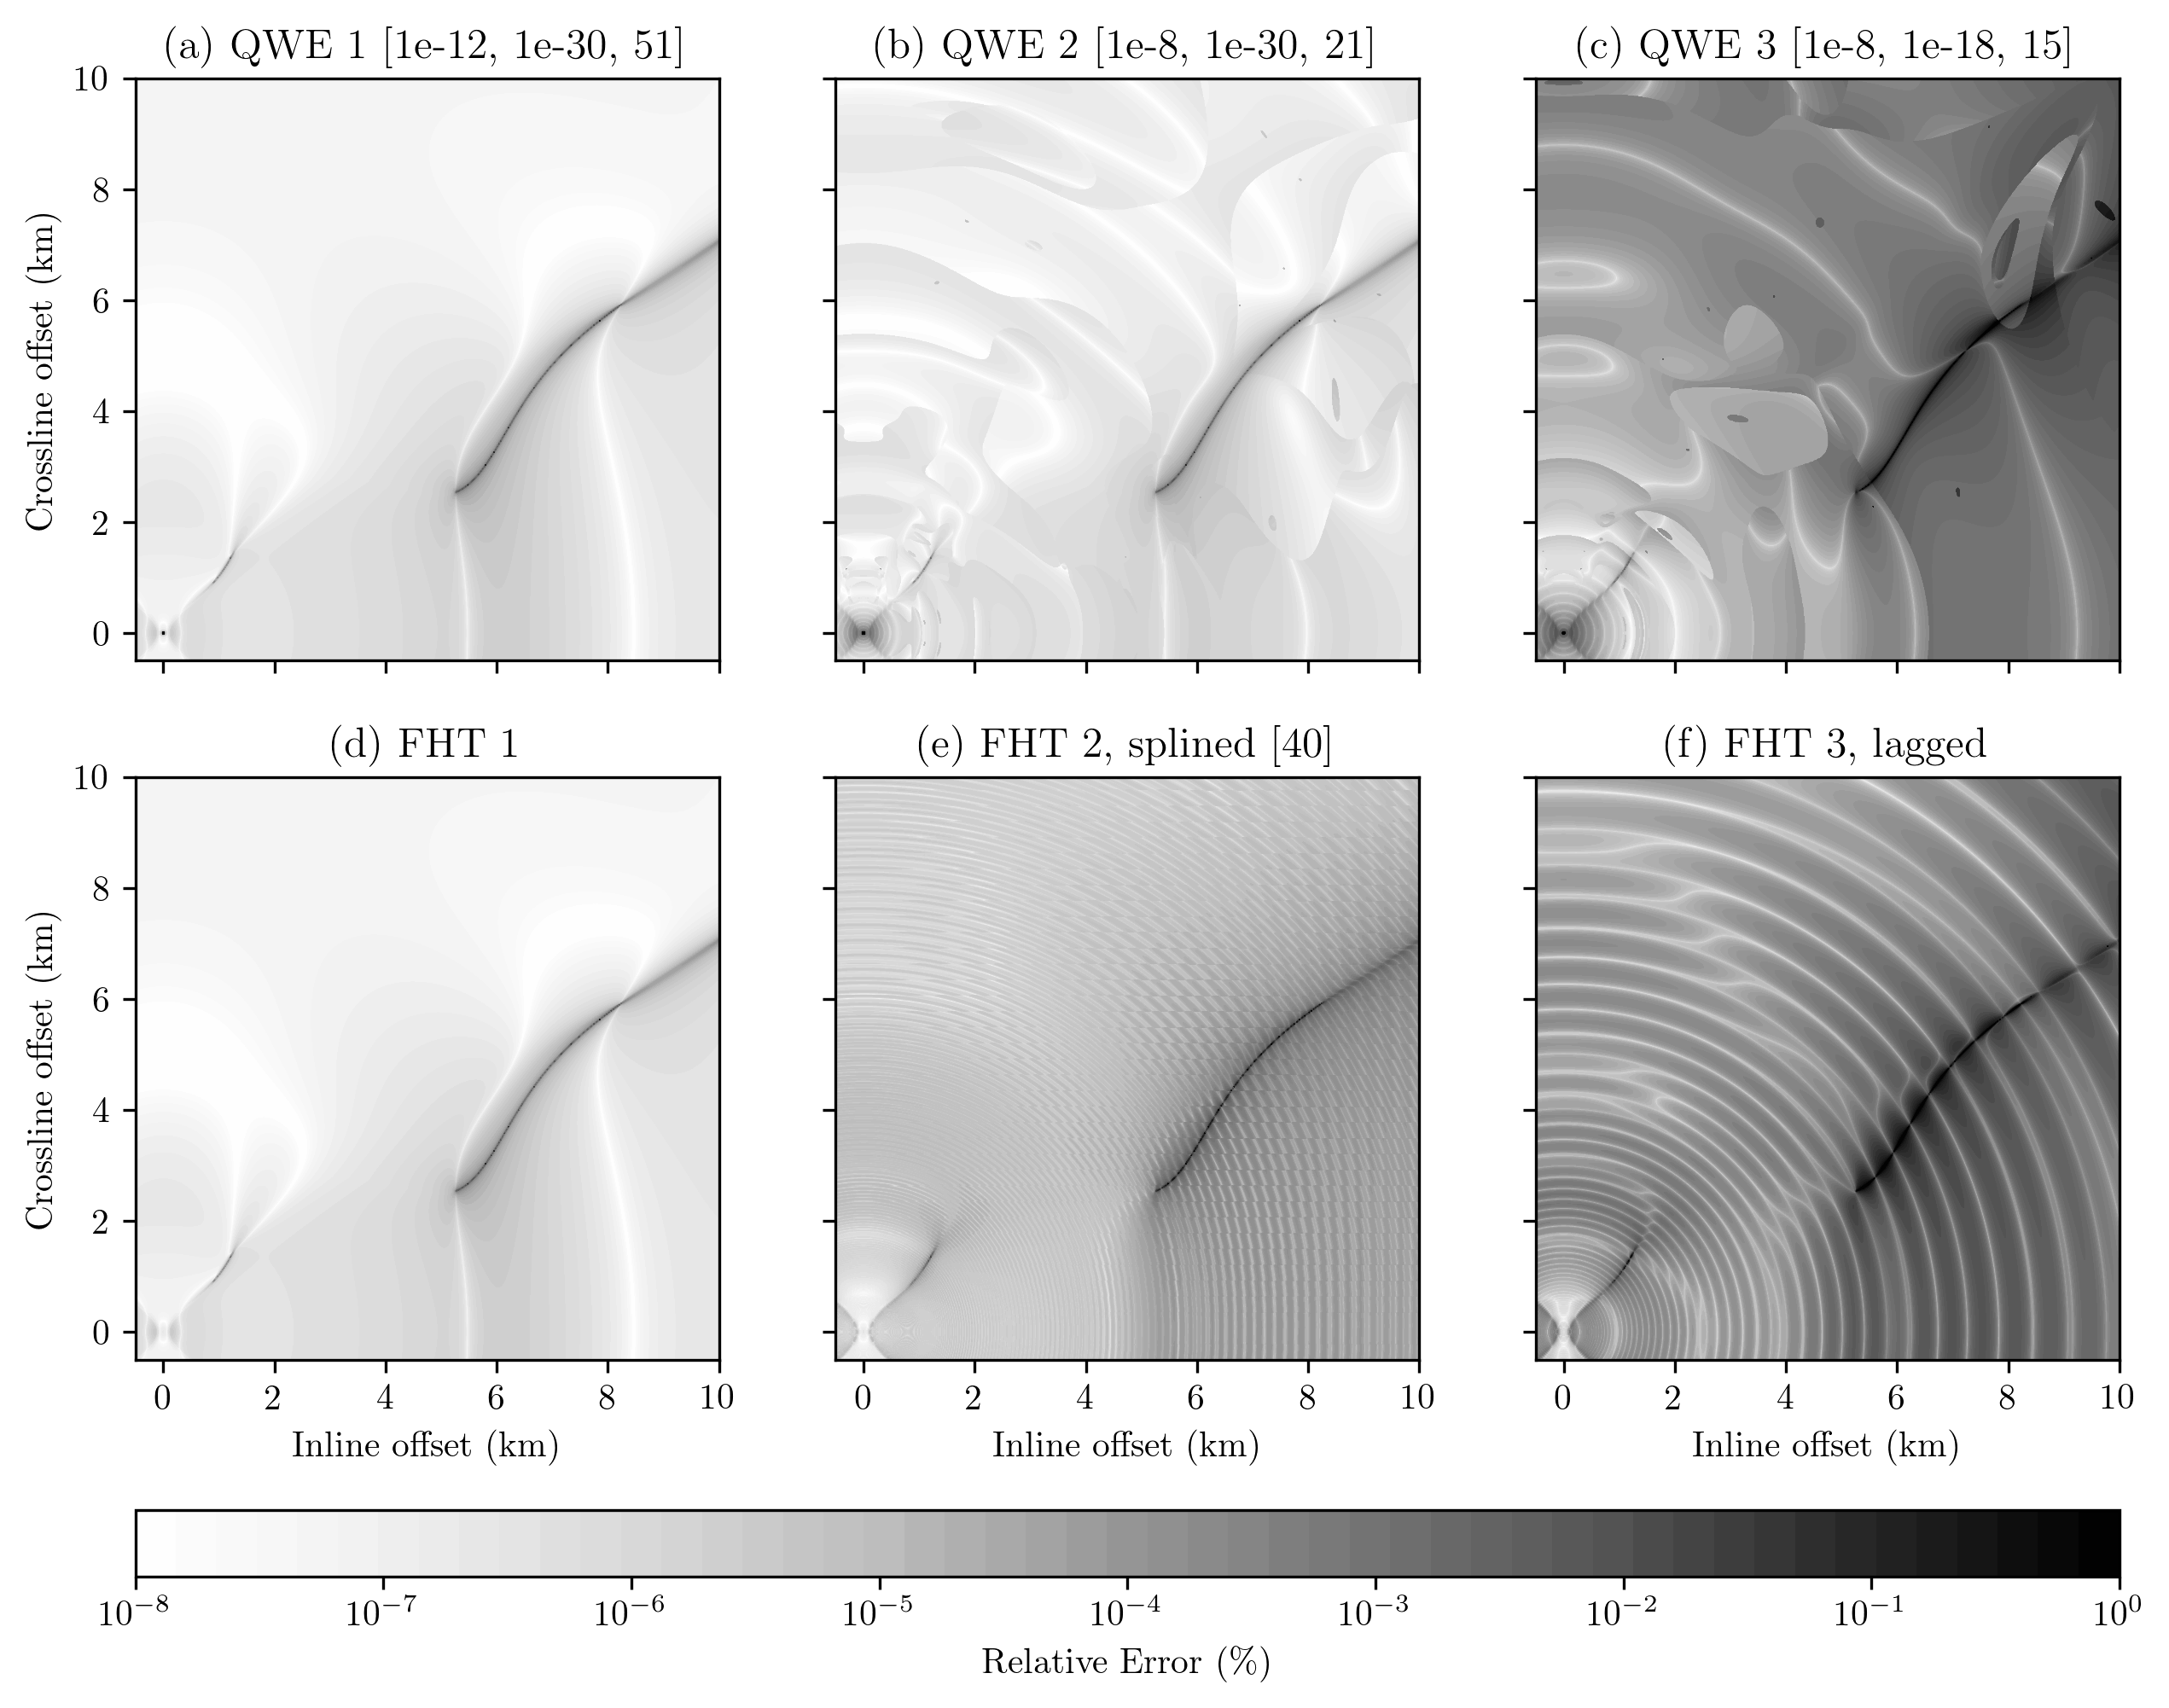

In [8]:
fig, axs = plt.subplots(figsize=(10, 7.8), facecolor = 'w', nrows=2, ncols=3, sharex=True, sharey=True)
axs = axs.ravel()

# Min and max, properties
vmin = 1e-8
vmax = 1e0
props = {'levels': np.logspace(np.log10(vmin), np.log10(vmax), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

# QWE 1
limits(0)
plt.title(r'(a) QWE 1 [1e-12, 1e-30, 51]')
cf1 = plt.contourf(rx/1000, ry/1000, qwe1pha.clip(vmin, vmax), **props)
plt.ylabel('Crossline offset (km)')

# QWE 2
limits(1)
plt.title(r'(b) QWE 2 [1e-8, 1e-30, 21]')
cf2 = plt.contourf(rx/1000, ry/1000, qwe2pha.clip(vmin, vmax), **props)

# QWE 3
limits(2)
plt.title(r'(c) QWE 3 [1e-8, 1e-18, 15]')
cf3 = plt.contourf(rx/1000, ry/1000, qwe3pha.clip(vmin, vmax), **props)

# FHT 1
limits(3)
plt.title(r'(d) FHT 1')
cf4 = plt.contourf(rx/1000, ry/1000, fht1pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')
plt.ylabel('Crossline offset (km)')
plt.xticks(np.arange(6)*2)

# FHT 2 (splined)
limits(4)
plt.title(r'(e) FHT 2, splined [40]')
cf5 = plt.contourf(rx/1000, ry/1000, fht2pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# FHT 3 (lagged)
limits(5)
plt.title(r'(f) FHT 3, lagged')
cf6 = plt.contourf(rx/1000, ry/1000, fht3pha.clip(vmin, vmax), **props)
plt.xlabel('Inline offset (km)')

# Plot colorbar
cax, kw = mpl.colorbar.make_axes([axs[0], axs[1], axs[2], axs[3], axs[4], axs[5]],
                                 location='bottom', fraction=.05, pad=0.1, aspect=30)
cb = plt.colorbar(cf6, cax=cax, ticks=10**(-(np.arange(11.)[::-1])+2), **kw)
cb.set_label(r'Relative Error $(\%)$')

# Save and show
plt.savefig('../figures/onederror-phase.jpg', bbox_inches='tight')
plt.show()

## Calculate `EMmod` results

To re-calculate the `EMmod`-Result `EMmod` must be installed and in the bash-PATH. Otherwise, you can use the result in `./data`.

In [9]:
# EMmod-result filename
ffile = './data/halfspacemod_11_10m.out'

# Create EMmod results if it does not exist
if not os.path.isfile(ffile):  # If results exist, load them
    os.chdir('data')
    subprocess.run('bash halfspacemod_10m.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    os.chdir('..')
    
# Read result and calculate error
with open(ffile, 'rb') as outfile:
    temp = np.loadtxt(outfile, skiprows=1, unpack=True)

    # Get same x/y as requested (round to mm)
    tct = np.round(temp[0], 3) + 1j*np.round(temp[1], 3)
    tcr = np.round(params['rec'][0], 3) + 1j*np.round(params['rec'][1], 3)
    itr = np.in1d(tct, tcr)

    # Put into data and reshape
    data = temp[3][itr] +1j*temp[4][itr]
    data = data.reshape(np.shape(rx))
    
    # Calculate error for amplitude and phase
    emmodamp = np.abs((np.abs(resp) - np.abs(data))/np.abs(resp))*100
    emmodpha = np.abs((np.angle(resp) - np.angle(data))/np.angle(resp))*100

## Plot amplitude and phase error of `EMmod`

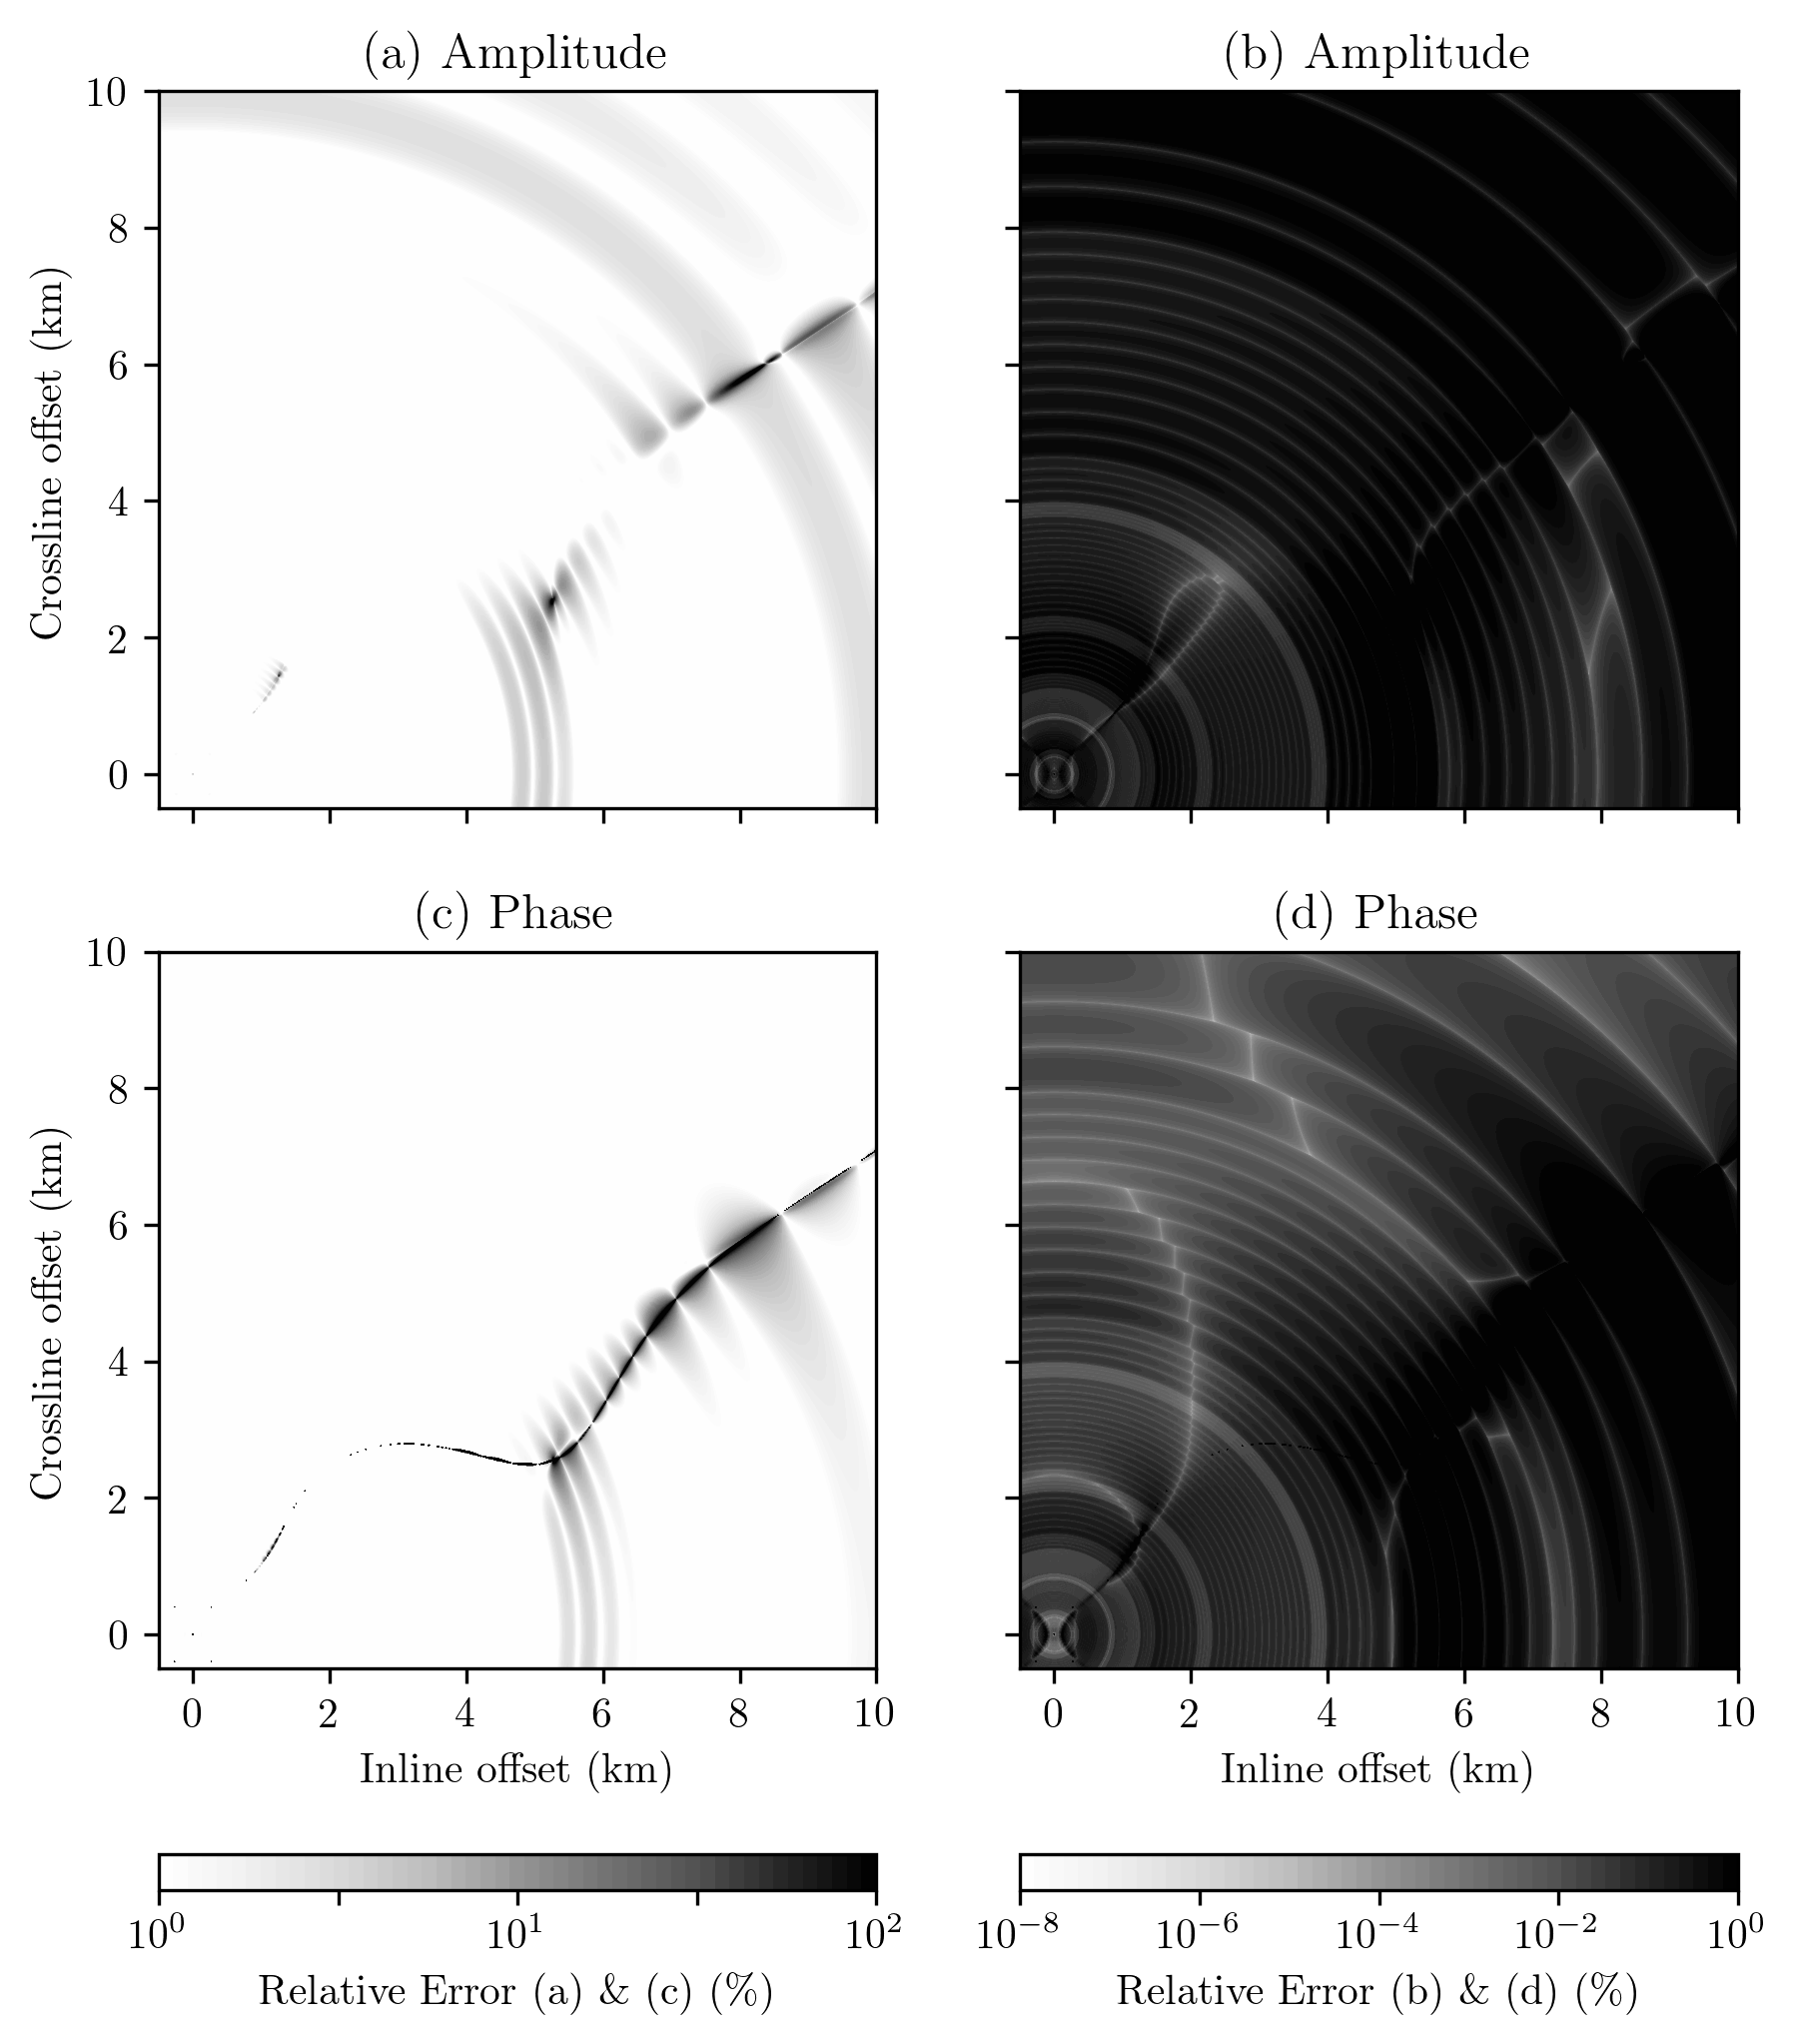

In [10]:
fig, axs = plt.subplots(figsize=(6.8, 8.2), facecolor = 'w', nrows=2, ncols=2, sharex=True, sharey=True)
axs = axs.ravel() 

# Properties for scale 0 to 2
vmin1 = 1e0
vmax1 = 1e2
props1 = {'levels': np.logspace(np.log10(vmin1), np.log10(vmax1), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

# Properties for scale -8 to 0 
vmin2 = 1e-8
vmax2 = 1e0
props2 = {'levels': np.logspace(np.log10(vmin2), np.log10(vmax2), 50), 'locator': mpl.ticker.LogLocator(), 'cmap': 'Greys'}

# 1. Amplitude on scale as 0 to 2
limits(0)
plt.title(r'(a) Amplitude')
cf1 = plt.contourf(rx/1000, ry/1000, emmodamp.clip(vmin1, vmax1), **props1)
plt.ylabel('Crossline offset (km)')
plt.xticks([0, 2, 4, 6, 8, 10])

# 2. Amplitude on scale -8 to 0
limits(1)
plt.title(r'(b) Amplitude')
cf2 = plt.contourf(rx/1000, ry/1000, emmodamp.clip(vmin2, vmax2), **props2)

# 3. Phase on scale 0 to 2
limits(2)
plt.title(r'(c) Phase')
cf3 = plt.contourf(rx/1000, ry/1000, emmodpha.clip(vmin1, vmax1), **props1)
plt.xlabel('Inline offset (km)')
plt.ylabel('Crossline offset (km)')

# 4. Phase on scale -8 to 0
limits(3)
plt.title(r'(d) Phase')
cf4 = plt.contourf(rx/1000, ry/1000, emmodpha.clip(vmin2, vmax2), **props2)
plt.xlabel('Inline offset (km)')

# Draw colorbar for scale 0 to 2
cax, kw = mpl.colorbar.make_axes([axs[0], axs[2]], location='bottom', fraction=.05, pad=0.1, aspect=20)
cb = plt.colorbar(cf3, cax=cax, ticks=10**(np.arange(5.)/2), **kw)
cb.set_label(r'Relative Error (a) \& (c) $(\%)$')

# Draw colorbar for scale -8 to 0
cax, kw = mpl.colorbar.make_axes([axs[1], axs[3]], location='bottom', fraction=.05, pad=0.1, aspect=20)
cb2 = plt.colorbar(cf4, cax=cax, ticks=10**(-(np.arange(11.)[::-2])+2), **kw)
cb2.set_label(r'Relative Error (b) \& (d) $(\%)$')

# Save figure and show it
plt.savefig('../figures/emmod-HS.jpg', bbox_inches='tight')
plt.show()

## Run times of `EMmod` and `empymod`

### A note on measuring runtimes.

I use the python function `timeit` to measure runtime for both, `EMmod` and `empymod`. In order to check that I do not compare the two codes unfairly, I run the following quick test:

In bash, I run `halfspacemod.src` 5 times, with the following result:

    ./data/> time bash halfspacemod.scr
    real    0m9.550s
    user    0m8.980s
    sys     0m0.568s
    
    ./data/> time bash halfspacemod.scr
    real    0m9.448s
    user    0m8.868s
    sys     0m0.576s

    ./data/> time bash halfspacemod.scr 
    real    0m9.489s
    user    0m8.924s
    sys     0m0.560s

    ./data/> time bash halfspacemod.scr 
    real    0m9.664s
    user    0m9.060s
    sys     0m0.600s

    ./data/> time bash halfspacemod.scr 
    real    0m9.514s
    user    0m8.920s
    sys     0m0.592s

Now in the Jupyter Notebook, I run `%timeit` with `subprocess` with the following result:

    %timeit subprocess.run('bash halfspacemod.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    1 loop, best of 3: 9.46 s per loop

Furthermore, I tested an empty call to `subprocess`, yielding:

    %timeit subprocess.run('', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
    100 loops, best of 3: 2.25 ms per loop

Hence the pure call to `subprocess` seems to take a little more than 2 ms, which is not a lot as the results of `EMmod` are usually in the seconds range. And as can be seen, the result of 9.46 s is on the lower range of the 5 results from bash. For this reasons I think it is fair to use `%timeit` within a Jupyter Notebook to time `EMmod`.

### Re-define coordinates, so it is a regular grid of 100 m spacing from 0 to 10 km, as in `halfspacemod_100m.scr`

In [11]:
x = (np.arange(101))*100
rx = np.repeat([x,],np.size(x),axis=0)
ry = rx.transpose()
params['rec'] = [rx.ravel(), ry.ravel(), 200]

### Time of `empymod`

In [12]:
%timeit dipole(**params, ht='qwe', htarg={'maxint': 40}, opt=None)
%timeit dipole(**params, ht='qwe', htarg=[1e-8, 1e-30, 21, 40], opt=None)
%timeit dipole(**params, ht='qwe', htarg=[1e-8, 1e-18, 15, 40], opt=None)

%timeit dipole(**params, ht='FHT', loop = None)
%timeit dipole(**params, ht='FHT', htarg = {'pts_per_dec': 40}, opt = 'spline')
%timeit dipole(**params, ht='FHT', opt = 'spline')

1 loop, best of 3: 10.3 s per loop
1 loop, best of 3: 2.53 s per loop
1 loop, best of 3: 1.21 s per loop
1 loop, best of 3: 1.48 s per loop
1 loop, best of 3: 875 ms per loop
100 loops, best of 3: 5.63 ms per loop


### Time of `EMmod`
Again, to run this test `EMmod` must be installed and in the bash-PATH.

In [13]:
os.chdir('data')
%timeit subprocess.run('bash halfspacemod_100m.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)
os.chdir('..')

1 loop, best of 3: 5.04 s per loop


In [14]:
import printinfo
printinfo.info()